<a href="https://colab.research.google.com/github/AI-Maker-Space/LLM-Ops-Vault/blob/main/Week%201/First%20Session/Barbie_Retrieval_Augmented_Question_Answering_(RAQA)_Assignment%20(Completed).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Questioning Barbie Reviews with RAQA (Retrieval Augmented Question Answering)

In the following notebook, you are tasked with creating a system that answers questions based on information found in reviews of the 2023 Barbie movie.

## Build 🏗️

There are 3 main tasks in this notebook:

1. Obtain and parse reviews from a review website
2. Create a Vectorstore from the reviews
3. Create a `RetrievalQA` chain 

## Ship 🚢

Create a Hugging Face Space that hosts your application.

## Share 🚀

Make a social media post about your final application.

>### Why RAQA and not RAG?
>If we look at the original [paper](https://arxiv.org/abs/2005.11401), we find that RAG is a fairly specific and well defined term that isn't exactly the same as "retrieve context, feed context to model in the prompt".
>For that reason, we're making the decision to delineate between "actual" RAG, and Retrieval Augmented Question Answering - which is not a well defined phrase.

### Pre-task Work

All we really need to do to get started is to get our prerequisites!

We'll be leveraging `langchain`, `openai`, and `pinecone` today.

Check out the docs:
- [LangChain](https://docs.langchain.com/docs/)
- [OpenAI](https://github.com/openai/openai-python)
- [Pinecone](https://docs.pinecone.io/docs/overview)

In [85]:
!pip install -q -U openai langchain "pinecone-client[grpc]"

In [86]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Open AI API Key:")

In [87]:
os.environ["PINECONE_API_KEY"] = getpass.getpass("Pinecone API Key:")

In [88]:
os.environ["PINECONE_ENV"] = getpass.getpass("Pinecone Environment:")

### Task 1: Data Preparation

In this task we'll be collecting, and then parsing, our data.

#### Scraping IMDB Reviews of Barbie

We'll use some Selenium based trickery to get the reviews we need to make our application.

Check out the docs here:
- [Selenium](https://www.selenium.dev/documentation/)

In [89]:
!pip install -q -U requests

In [90]:
!pip install -q -U scrapy selenium

You will need to install the `chromium-chromedriver` in order to use the method presented. 

`!apt install chromium-chromedriver` will install the chromedriver. 

You may have to use your terminal if you receive an error related to `sudo`. In that case, please use (in your terminal) `sudo apt install chromium-chromedriver`.

Otherwise, the `.csv` is provided and can be loaded through `pandas` if you're experiencing issues relating to the web-scraping portion of the notebook.

In [91]:
import numpy as np
import pandas as pd
from scrapy.selector import Selector
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [92]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome(options=chrome_options)

In [93]:
url = "https://www.imdb.com/title/tt1517268/reviews/?ref_=tt_ov_rt"
driver.get(url)

In [94]:
sel = Selector(text = driver.page_source)
review_counts = sel.css('.lister .header span::text').extract_first().replace(',','').split(' ')[0]
more_review_pages = int(int(review_counts)/25)

In [95]:
for i in tqdm(range(more_review_pages)):
    try:
        css_selector = 'load-more-trigger'
        driver.find_element(By.ID, css_selector).click()
    except:
        pass

100%|██████████| 55/55 [00:00<00:00, 74.43it/s]


In [96]:
rating_list = []
review_date_list = []
review_title_list = []
author_list = []
review_list = []
review_url_list = []
error_url_list = []
error_msg_list = []
reviews = driver.find_elements(By.CSS_SELECTOR, 'div.review-container')

for d in tqdm(reviews):
    try:
        sel2 = Selector(text = d.get_attribute('innerHTML'))
        try:
            rating = sel2.css('.rating-other-user-rating span::text').extract_first()
        except:
            rating = np.NaN
        try:
            review = sel2.css('.text.show-more__control::text').extract_first()
        except:
            review = np.NaN
        try:
            review_date = sel2.css('.review-date::text').extract_first()
        except:
            review_date = np.NaN
        try:
            author = sel2.css('.display-name-link a::text').extract_first()
        except:
            author = np.NaN
        try:
            review_title = sel2.css('a.title::text').extract_first()
        except:
            review_title = np.NaN
        try:
            review_url = sel2.css('a.title::attr(href)').extract_first()
        except:
            review_url = np.NaN
        rating_list.append(rating)
        review_date_list.append(review_date)
        review_title_list.append(review_title)
        author_list.append(author)
        review_list.append(review)
        review_url_list.append(review_url)
    except Exception as e:
        error_url_list.append(url)
        error_msg_list.append(e)
review_df = pd.DataFrame({
    'Review_Date':review_date_list,
    'Author':author_list,
    'Rating':rating_list,
    'Review_Title':review_title_list,
    'Review':review_list,
    'Review_Url':review_url
    })

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 191.28it/s]


In [97]:
review_df

,Review_Date,Author,Rating,Review_Title,Review,Review_Url
0,21 July 2023,LoveofLegacy,6,"Beautiful film, but so preachy\n","Margot does the best with what she's given, bu...",/review/rw9240889/?ref_=tt_urv
1,26 July 2023,aherdofbeautifulwildponies,6,A Hot Pink Mess\n,"Before making Barbie (2023),",/review/rw9240889/?ref_=tt_urv
2,22 July 2023,imseeg,7,3 reasons FOR seeing it and 1 reason AGAINST.\n,The first reason to go see it:,/review/rw9240889/?ref_=tt_urv
3,31 July 2023,ramair350,10,"As a guy I felt some discomfort, and that's o...",As much as it pains me to give a movie called ...,/review/rw9240889/?ref_=tt_urv
4,22 July 2023,Natcat87,6,Too heavy handed\n,"As a woman that grew up with Barbie, I was ver...",/review/rw9240889/?ref_=tt_urv
...,...,...,...,...,...,...
95,28 July 2023,mohamed-elbehairy,6,Had some good moments but that's it\n,"I found the movie to be refreshing, but it's f...",/review/rw9240889/?ref_=tt_urv
96,21 July 2023,jonathanruano,2,Barbie - Unspeakably Bad\n,I am not surprised in the least that the Barbi...,/review/rw9240889/?ref_=tt_urv
97,21 July 2023,bankofmarquis,8,More Than Meets The Eye\n,The Margot Robbie/Ryan Gosling curiosity BARBI...,/review/rw9240889/?ref_=tt_urv
98,24 July 2023,steveinadelaide,6,Cute but shallow\n,"So I headed to the cinema to watch Barbie, the...",/review/rw9240889/?ref_=tt_urv


Let's save this `pd.DataFrame` as a `.csv` to our local session (this will be terminated when you terminate the Colab session) so we can leverage it in LangChain!

In [98]:
review_df.to_csv("../data/barbie1.csv")

In [99]:
data = review_df

In [100]:
data=pd.read_csv("../data/barbie.csv")

#### Data Parsing

Now that we have our data - let's go ahead and set up some tools to parse it into a more usable format for LangChain!

Our reviews might contain a lot of information, and in order to ensure they don't exceed the context window of our model and to allow us to include a few reviews as context for each query - let's construct a system to "chunk" our data into smaller pieces.

We'll be leveraging the `RecursiveCharacterTextSplitter` for this task today.

While splitting our text seems like a simple enough task - getting this correct/incorrect can have massive downstream impacts on your application's performance.

You can read the docs here:
- [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/modules/data_connection/document_transformers/text_splitters/recursive_text_splitter)

> ### HINT:
>It's always worth it to check out the LangChain source code if you're ever in a bind - for instance, if you want to know how to transform a set of documents, check it out [here](https://github.com/langchain-ai/langchain/blob/5e9687a196410e9f41ebcd11eb3f2ca13925545b/libs/langchain/langchain/text_splitter.py#L268C18-L268C18)

In [101]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000, # the character length of the chunk
    chunk_overlap = 100, # the character length of the overlap between chunks
    length_function = len, # the length function - in this case, character length (aka the python len() fn.)
)

Now that we have our `RecursiveCharacterTextSplitter` set up - let's look at how it might split our source text. 

Keep in mind that the source text is split by `["\n\n", "\n", " ", ""]` in that order.

We know that each of the subheadings in our review `page_content` is separated by a newline character, so it will preferably chunk the review subheadings together. 

That's great! Let's move on to creating our index!

### Task 2: Creating an "Index"

The term "index" is used largely to mean: Structured documents parsed into a useful format for querying, retrieving, and use in the LLM application stack.

#### Selecting Our VectorStore

There are a number of different VectorStores, and a number of different strengths and weaknesses to each.

In this notebook, we will be keeping it very simple by leveraging Pinecone's API Vector Database.

In [102]:
!pip install -q -U tiktoken

Let's set up a Pinecone index using the methods provided in their [documentation](https://docs.pinecone.io/docs/langchain)!

In [103]:
import pinecone

YOUR_API_KEY = os.environ["PINECONE_API_KEY"]
YOUR_ENV = os.environ["PINECONE_ENV"]

index_name = 'barbie-review-index'

pinecone.init(
    api_key=YOUR_API_KEY,
    environment=YOUR_ENV
)

if index_name not in pinecone.list_indexes():
    # we create a new index
    pinecone.create_index(
        name=index_name,
        metric='cosine',
        dimension=1536
    )

Now we can connect to our index and view some statistics about it.

In [104]:
index = pinecone.GRPCIndex(index_name)

index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 0}},
 'total_vector_count': 0}

We're going to be setting up our VectorStore with the OpenAI embeddings model. While this embeddings model does not need to be consistent with the LLM selection, it does need to be consistent between embedding our index and embedding our queries over that index.

While we don't have to worry too much about that in this example - it's something to keep in mind for more complex applications.

We're going to leverage a [`CacheBackedEmbeddings`](https://python.langchain.com/docs/modules/data_connection/caching_embeddings )flow to prevent us from re-embedding similar queries over and over again.

Not only will this save time, it will also save us precious embedding tokens, which will reduce the overall cost for our application.

>#### Note:
>The overall cost savings needs to be compared against the additional cost of storing the cached embeddings for a true cost/benefit analysis. If your users are submitting the same queries often, though, this pattern can be a massive reduction in cost.

In [105]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.embeddings import CacheBackedEmbeddings
from langchain.storage import LocalFileStore

store = LocalFileStore("./cache/")

core_embeddings_model = OpenAIEmbeddings()

embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings_model, store, namespace=core_embeddings_model.model
)

Now that we have our `CacheBackedEmbeddings` pipeline set-up, let's index our documents into our Pinecone Vector Database. 

We'll add some useful metadata as well!

In [106]:
data.head(1)

,Unnamed: 0,Review_Date,Author,Rating,Review_Title,Review,Review_Url
0,0,21 July 2023,LoveofLegacy,6.0,"Beautiful film, but so preachy\n","Margot does the best with what she's given, bu...",/review/rw9221648/?ref_=tt_urv


In [107]:
from tqdm.auto import tqdm
from uuid import uuid4

BATCH_LIMIT = 100

texts = []
metadatas = []

for i in tqdm(range(len(data))):

    record = data.iloc[i]

    metadata = {
        'review-url': str(record["Review_Url"]),
        'review-date' : str(record["Review_Date"]),
        'author' : str(record["Author"]),
        'rating' : str(record["Rating"]),
        'review-title' : str(record["Review_Title"]),
    }

    record_texts = text_splitter.split_text(record["Review"])

    record_metadatas = [{
        "chunk": j, "text": text, **metadata
    } for j, text in enumerate(record_texts)]
    texts.extend(record_texts)
    metadatas.extend(record_metadatas)
    if len(texts) >= BATCH_LIMIT:
        ids = [str(uuid4()) for _ in range(len(texts))]
        embeds = embedder.embed_documents(texts)
        index.upsert(vectors=zip(ids, embeds, metadatas))
        texts = []
        metadatas = []

if len(texts) > 0:
    ids = [str(uuid4()) for _ in range(len(texts))]
    embeds = embedder.embed_documents(texts)
    index.upsert(vectors=zip(ids, embeds, metadatas))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 210.53it/s]


In [108]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 0}},
 'total_vector_count': 0}

Now that we've created our index, let's convert it to a LangChain `VectorStroe` so we can use it in the rest of the LangChain ecosystem!

In [109]:
from langchain.vectorstores import Pinecone

text_field = "text"

index = pinecone.Index(index_name)

vectorstore = Pinecone(
    index, embedder.embed_query, text_field
)

Now that we've created the VectorStore, we can check that it's working by embedding a query and retrieving passages from our reviews that are close to it.

In [111]:
query = "Who played Ken?"

vectorstore.similarity_search(
    query, 
    k=3  
)

[Document(page_content="The film's universe and settings are fantastic. The casting is really good too, with Gosling excelling in the role of Ken.", metadata={'author': 'hamsterination', 'chunk': 0.0, 'rating': '6.0', 'review-date': datetime.datetime(2023, 7, 19, 0, 0), 'review-title': ' It could have been so much better...\n', 'review-url': '/review/rw9221648/?ref_=tt_urv'}),
 Document(page_content='This movie is so much fun. It starts off really strong although the story does move away from "Barbieland" sooner than I would have liked. Nonetheless, it regains its footing with the final act in particular and I could not stop laughing at Ryan Gosling\'s portrayal of Ken. That song will forever be stuck in my head.', metadata={'author': 'Genti25', 'chunk': 0.0, 'rating': '8.0', 'review-date': datetime.datetime(2023, 7, 20, 0, 0), 'review-title': ' You are Kenough\n', 'review-url': '/review/rw9221648/?ref_=tt_urv'}),
 Document(page_content='I mean, Margo Robbie as Barbie just made perfect

Let's see how much time the `CacheBackedEmbeddings` pattern saves us:

In [112]:
%%timeit
query = "I really wanted to enjoy this and I know that I am not the target audience but there were massive plot holes and no real flow."
vectorstore.similarity_search(
    query, 
    k=3  
)

The slowest run took 6.05 times longer than the fastest. This could mean that an intermediate result is being cached.
650 ms ± 406 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As we can see, even over a significant number of runs - the cached query is significantly faster than the first instance of the query!

With that, we're ready to move onto Task 3!

### Task 3: Building a Retrieval Chain

In this task, we'll be making a Retrieval Chain which will allow us to ask semantic questions over our data.

This part is rather abstracted away from us in LangChain and so it seems very powerful.

Be sure to check the documentation, the source code, and other provided resources to build a deeper understanding of what's happening "under the hood"!

#### A Basic RetrievalQA Chain

We're going to leverage `return_source_documents=True` to ensure we have proper sources for our reviews - should the end user want to verify the reviews themselves.

Hallucinations [are](https://arxiv.org/abs/2202.03629) [a](https://arxiv.org/abs/2305.15852) [massive](https://arxiv.org/abs/2303.16104) [problem](https://arxiv.org/abs/2305.18248) in LLM applications.

Though it has been tenuously shown that using Retrieval Augmentation [reduces hallucination in conversations](https://arxiv.org/pdf/2104.07567.pdf), one sure fire way to ensure your model is not hallucinating in a non-transparent way is to provide sources with your responses. This way the end-user can verify the output.

#### Our LLM

In this notebook, we'll continue to leverage OpenAI's suite of models - this time we'll be using the `gpt-3.5-turbo` model to power our RetrievalQAWithSources chain.

In [113]:
from langchain.llms.openai import OpenAIChat

llm = OpenAIChat(model="gpt-3.5-turbo", temperature=0)

Now we can set up our chain.

In [114]:
retriever = vectorstore.as_retriever()

In [115]:
from langchain.chains import RetrievalQA
from langchain.callbacks import StdOutCallbackHandler

handler = StdOutCallbackHandler()

qa_with_sources_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    callbacks=[handler],
    return_source_documents=True
)

In [116]:
qa_with_sources_chain({"query" : "How was Will Ferrell in this movie?"})["result"]



> Entering new RetrievalQA chain...

> Finished chain.


'Will Ferrell ruined every scene he was in.'

In [117]:
qa_with_sources_chain({"query" : "Do reviewers consider this movie Kenough?"})["result"]



> Entering new RetrievalQA chain...

> Finished chain.


'Based on the given context, it is unclear whether reviewers consider this movie "Kenough" or not.'

Let's look at the available metadata we have, thanks to our index-creation!

In [118]:
result = qa_with_sources_chain({"query" : "Was Will Ferrel funny?"})



> Entering new RetrievalQA chain...

> Finished chain.


In [119]:
for k, v in result.items():
    print(f"Key: {k}")
    print(f"Value: {v}")
    print("")

Key: query
Value: Was Will Ferrel funny?

Key: result
Value: Yes, the person states that Will Ferrell ruined every scene he was in.

Key: source_documents
Value: [Document(page_content="I really wanted to enjoy this and I know that I am not the target audience but there were massive plot holes and no real flow. The film was very disjointed. Ryan Gosling as good as he is seemed to old to play Ken and Will Ferrell ruined every scene he was in. I just didn't get it, it seemed hollow artificial and hackneyed. A waste of some great talent. It was predictable without being reassuring and trying so hard to be woke in the most superficial way in that but trying to tick so many boxes it actually ticked none. Margo Robbie looks beautiful throughout, the costumes and the sets were amazing but the story was way too weak and didn't make much sense at all.", metadata={'author': 'agjbull', 'chunk': 0.0, 'rating': '6.0', 'review-date': datetime.datetime(2023, 7, 23, 0, 0), 'review-title': ' Just a lit

In [120]:
for page_content, metadata in result["source_documents"]:
    print(f"Metadata: {metadata}")
    print(f"Page Content: {page_content}")
    print("")

Metadata: ('metadata', {'author': 'agjbull', 'chunk': 0.0, 'rating': '6.0', 'review-date': datetime.datetime(2023, 7, 23, 0, 0), 'review-title': ' Just a little empty\n', 'review-url': '/review/rw9221648/?ref_=tt_urv'})
Page Content: ('page_content', "I really wanted to enjoy this and I know that I am not the target audience but there were massive plot holes and no real flow. The film was very disjointed. Ryan Gosling as good as he is seemed to old to play Ken and Will Ferrell ruined every scene he was in. I just didn't get it, it seemed hollow artificial and hackneyed. A waste of some great talent. It was predictable without being reassuring and trying so hard to be woke in the most superficial way in that but trying to tick so many boxes it actually ticked none. Margo Robbie looks beautiful throughout, the costumes and the sets were amazing but the story was way too weak and didn't make much sense at all.")

Metadata: ('metadata', {'author': 'Revuer223', 'chunk': 0.0, 'rating': '6.0'

### Adding Prompt Caching and Monitoring

Now that we have the basic `RetrievalQAChain` set up and working - let's add a few more tools to help us built a more performant application and add a visibility tool as well!

#### Visibility Tooling

We'll be once again leveraging Weights and Biases as our visibility tool, so let's add that first!

You'll want to use the same Weights and Biases account that you set-up last Thursday here!

In [121]:
os.environ["WANDB_API_KEY"] = getpass.getpass("Weights and Biases API Key:")
os.environ["WANDB_PROJECT"] = "barbie-retrieval-qa"

Now, to set up WandB, all we have to do is...

In [122]:
os.environ["LANGCHAIN_WANDB_TRACING"] = "true"

Yes, that's it. 

Let's use our `RetrievalQA` chain to test it out!

In [123]:
qa_with_sources_chain({"query" : "Do reviewers consider this movie Kenough?"})["result"]



> Entering new RetrievalQA chain...

> Finished chain.


'Based on the given context, it is unclear whether reviewers consider this movie "Kenough" or not.'

With those simple lines of code - we've added full visibility to our prompts and responses through Weights and Biases! 

#### Prompt Caching


### Adding A Prompt Cache

The basic idea of Prompt Caching is to provide a way to circumvent going to the LLM for prompts we have already seen.

Similar to cached embeddings, the idea is simple:

- Keep track of all the input/output pairs
- If a user query is (in the case of semantic similarity caches) close enough to a previous prompt contained in the cache, return the output associated with that pair

### Initializing a Prompt Cache

There are many different tools you can use to implement a Prompt Cache - from a "build it yourself" VectorStore implementation - to Redis - to custom libraries - there are upsides and downsides to each solution. 

Let's look at the Redis-backed Cache vs. `InMemoryCache` as an example:

Redis Cache
| Pros  | Cons  |
|---|---|
| Managed and Robust  | Expensive to Host  |
| Integrations on all Major Cloud Platforms  | Non-trivial to Integrate |
| Easily Scalable  | Does not have a ChatModel implementation |

`InMemoryCache`
| Pros  | Cons  |
|---|---|
| Easily implemented  | Consumes potentially precious memory |
| Completely Cloud Agnostic  | Does not offer inter-session caching |

For the sake of ease of use - and to allow functionality with our `ChatOpenAI` model - we'll leverage `InMemoryCache`.

We need to set our `langchain.llm_cache` to use the `InMemoryCache`.

- [`InMemoryCache`](https://api.python.langchain.com/en/latest/cache/langchain.cache.InMemoryCache.html)

In [124]:
import langchain
from langchain.cache import InMemoryCache
langchain.llm_cache = InMemoryCache()

One more important fact about the `InMemoryCache` is that it is what's called an "exact-match" cache - meaning it will only trigger when the user query is *exactly* represented in the cache. 

This is a safer cache, as we can guarentee the user's query exactly matches with previous queries and we don't have to worry about edge-cases where semantic similarity might fail - but it does reduce the potential to hit the cache.

We could leverage tools like `GPTCache`, or `RedisCache` (for non-chat model implementations) to get a "semantic similarity" cache, if desired!

In [125]:
%%time
qa_with_sources_chain({"query" : "Do reviewers consider this movie Kenough?"})["result"]



> Entering new RetrievalQA chain...

> Finished chain.
CPU times: user 12.3 ms, sys: 3.31 ms, total: 15.6 ms
Wall time: 2.62 s


'Based on the given context, it is unclear whether reviewers consider this movie "Kenough" or not.'

In [126]:
%%time
qa_with_sources_chain({"query" : "Do reviewers consider this movie Kenough?"})["result"]



> Entering new RetrievalQA chain...

> Finished chain.
CPU times: user 11.7 ms, sys: 2.16 ms, total: 13.9 ms
Wall time: 246 ms


'Based on the given context, it is unclear whether reviewers consider this movie "Kenough" or not.'

Let's look at an example that is extremely close - but is not the exact query.

In [127]:
%%time
qa_with_sources_chain({"query" : "Do reviewers consider this here movie Kenough?"})["result"]



> Entering new RetrievalQA chain...

> Finished chain.
CPU times: user 12.6 ms, sys: 2.69 ms, total: 15.2 ms
Wall time: 2.48 s


'Based on the given context, it is unclear whether reviewers consider this movie "Kenough" or not.'

As you can see, adding an exact-match prompt cache is a very small lift - but it can significantly improve the latency of your end-user application experience!

### Conclusion

And with that, we have our Barbie Review RAQA Application built!

Let's port it into a Chainlit app and put it up on a Hugging Face Space!

## RAG architecture 
[Source link](https://www.hopsworks.ai/dictionary/retrieval-augmented-generation-llm)

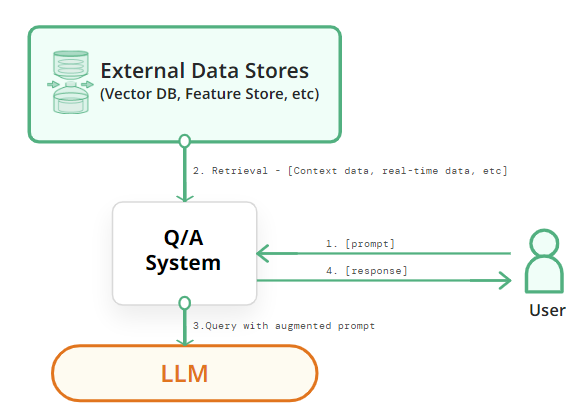